In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer

# Import Dataframes

In [2]:
labeled_df = pd.read_csv('nov2.1_df.csv', index_col = False)
labeled_df.drop(columns='Unnamed: 0', inplace=True)
labeled_df.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound
0,0,RT @JulianCastro: My grandmother was a domesti...,10/29/2019 22:56,0.000,0.000,1.000,0.0000
1,1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,10/29/2019 22:56,0.000,0.000,1.000,0.0000
2,1,Getty Fire Ignited by Power Line in Sepulveda ...,10/29/2019 22:56,0.000,0.211,0.789,-0.3400
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859
4,1,Arson investigators from the Los Angeles Fire ...,10/29/2019 22:56,0.066,0.122,0.812,-0.2732


## Binarize

In [3]:
labeled_df['word_count'] = labeled_df['text'].apply(lambda x: len(x.split()))
labeled_df['character_count'] =  labeled_df['text'].str.len()
labeled_df['mention_count'] = labeled_df['text'].apply(lambda x: str.count(x, '@'))

In [4]:
labeled_df['mention'] = np.where(labeled_df['text'].str.contains('@'), 1, 0)
labeled_df['https'] = np.where(labeled_df['text'].str.contains('http'), 1,0)
labeled_df['newsom_mention'] = np.where(labeled_df['text'].str.contains('@GavinNewsom'), 1, 0)
labeled_df['garcetti_mention'] = np.where(labeled_df['text'].str.contains('@MayorOfLA'), 1, 0)
labeled_df['harris_mention'] = np.where(labeled_df['text'].str.contains('@KamalaHarris'), 1, 0)
labeled_df['cal_fire'] = np.where(labeled_df['text'].str.contains('@CAL_FIRE'), 1, 0)

In [5]:
labeled_df.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound,word_count,character_count,mention_count,mention,https,newsom_mention,garcetti_mention,harris_mention,cal_fire
0,0,RT @JulianCastro: My grandmother was a domesti...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,21,154,1,1,0,0,0,0,0
1,1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,21,156,2,1,0,0,1,0,0
2,1,Getty Fire Ignited by Power Line in Sepulveda ...,10/29/2019 22:56,0.000,0.211,0.789,-0.3400,10,76,0,0,1,0,0,0,0
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859,22,174,1,1,0,0,0,0,0
4,1,Arson investigators from the Los Angeles Fire ...,10/29/2019 22:56,0.066,0.122,0.812,-0.2732,19,152,0,0,1,0,0,0,0


In [6]:
labeled_df['mention'].value_counts(normalize = True)

0    0.733675
1    0.266325
Name: mention, dtype: float64

## Investigating Word Count

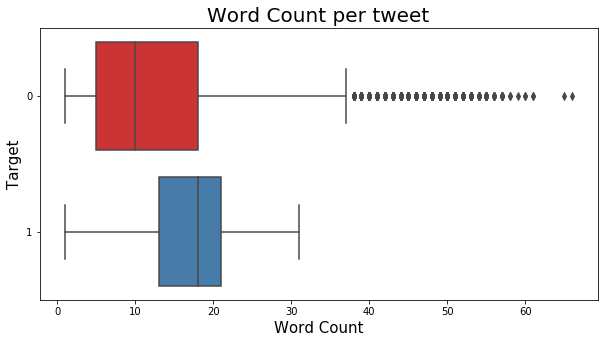

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'word_count', y = 'target', data = labeled_df, orient="h", palette="Set1")
plt.title('Word Count per tweet', fontsize = 20)
plt.xlabel("Word Count", fontsize = 15)
plt.ylabel("Target", fontsize = 15);

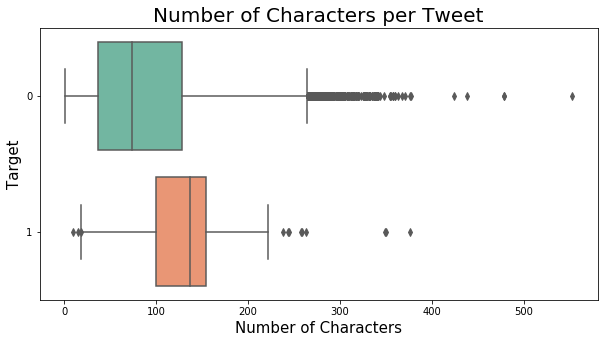

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'character_count', y = 'target', data = labeled_df, orient="h", palette="Set2")
plt.title('Number of Characters per Tweet', fontsize = 20)
plt.xlabel("Number of Characters", fontsize = 15)
plt.ylabel("Target", fontsize = 15);

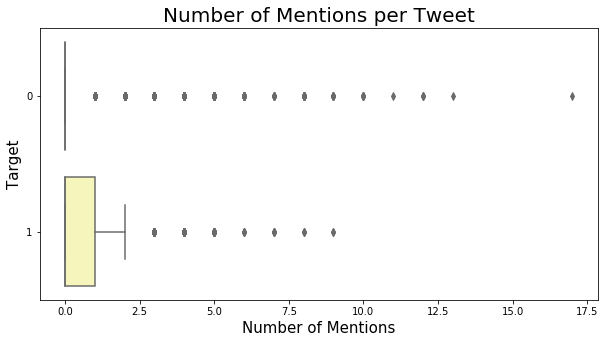

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.boxplot(x = 'mention_count', y = 'target', data = labeled_df, orient="h", palette="Set3")
plt.title('Number of Mentions per Tweet', fontsize = 20)
plt.xlabel("Number of Mentions", fontsize = 15)
plt.ylabel("Target", fontsize = 15);

## Stop words

In [10]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(["b'RT",
                    "000",
                    "x80",
                    "x82"
                    "x8f",
                    "x99",
                    "x94",
                    "x98",
                    "x99m", 
                    "x99s",
                    "x9d",
                    "x9f",
                    "xa5",
                    "xa6",
                    "xa6'RT",
                    "xa6'b'RT",
                    "xa6'b'",
                    "xb8",
                    "xe2",
                    "xef",
                    "xf0",
                    "amp",
                    'angele',
                    'angeles',
                    "b'",
                    "Center",
                    'center',
                    'com',
                    "Getty",
                    'getty',
                    'gettyfire',
                    "Getty Center",
                    "GettyFire",
                    'kincade',
                    "instagram"
                    "htpps",
                    "http",
                    "nhttp", 
                    "nhttps",
                    'los',
                    "Los Angeles",
                    "Los Angele",
                    "Los", "Angele",
                    "outfit",
                    'rd',
                    'rt',
                    "taco",
                    "tick",
                    "truck",
                    "taco truck",
                    "www"
                    
                    
            ])

## CVEC

In [11]:
X = labeled_df['text']

In [12]:
cvec = CountVectorizer(stop_words = custom_stop, ngram_range=(1,1))

words_df = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()

)

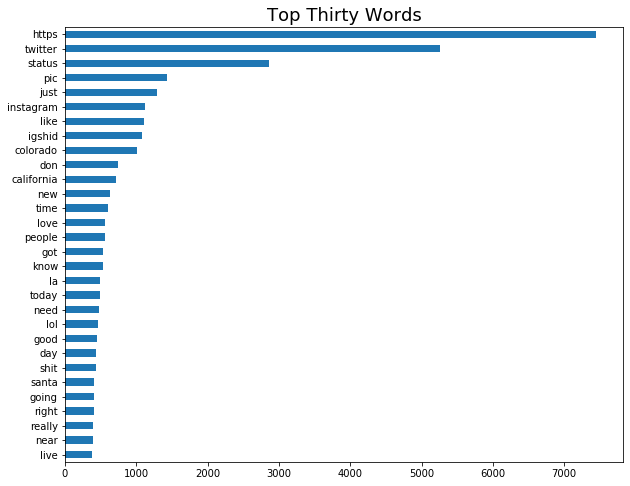

In [13]:
top_30 = words_df.sum().sort_values(ascending = True).tail(30)
plt.title('Top Thirty Words', fontsize = 18)
top_30.plot.barh(figsize = (10,8))

## Bigram

In [33]:
cvec = CountVectorizer(stop_words = custom_stop, ngram_range=(2,2))

bigram_df = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()

)

MemoryError: 

In [ ]:
bigram_top_30 = bigram_df.sum().sort_values(ascending = True).tail(30)
plt.title('Top Thirty Words', fontsize = 18)
bigram_top_30.plot.barh(figsize = (10,8))

## Trigram

In [ ]:
cvec = CountVectorizer(stop_words = custom_stop, ngram_range=(3,3))

trigram_df = pd.DataFrame(
    cvec.fit_transform(X).todense(),
    columns = cvec.get_feature_names()

)

In [ ]:
trigram_top_30 = trigram_df.sum().sort_values(ascending = True).tail(30)
plt.title('Top Thirty Words', fontsize = 18)
trigram_top_30.plot.barh(figsize = (10,8))

## Sentiment Analysis

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
labeled_df.shape

(24410, 16)

In [18]:
labeled_df.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound,word_count,character_count,mention_count,mention,https,newsom_mention,garcetti_mention,harris_mention,cal_fire
0,0,RT @JulianCastro: My grandmother was a domesti...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,21,154,1,1,0,0,0,0,0
1,1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,21,156,2,1,0,0,1,0,0
2,1,Getty Fire Ignited by Power Line in Sepulveda ...,10/29/2019 22:56,0.000,0.211,0.789,-0.3400,10,76,0,0,1,0,0,0,0
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859,22,174,1,1,0,0,0,0,0
4,1,Arson investigators from the Los Angeles Fire ...,10/29/2019 22:56,0.066,0.122,0.812,-0.2732,19,152,0,0,1,0,0,0,0


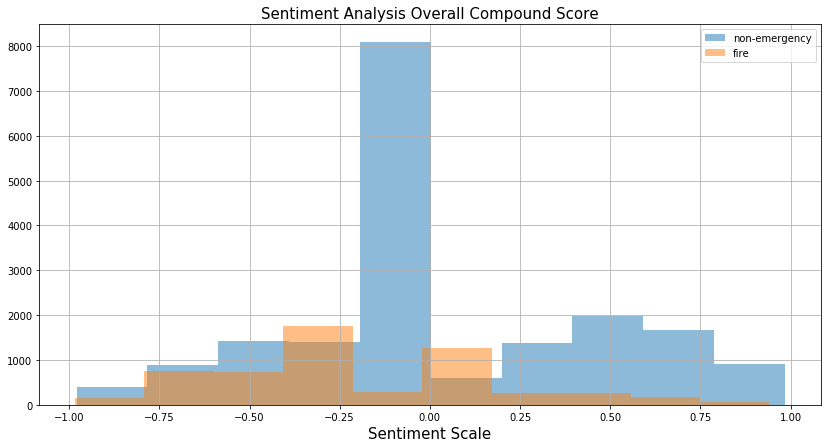

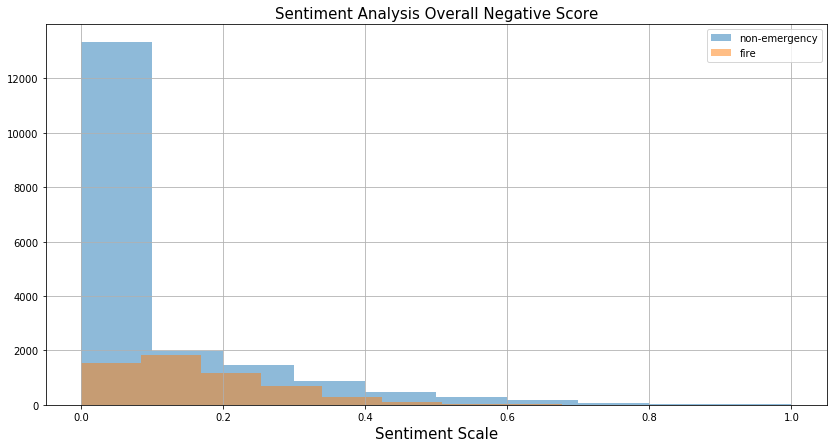

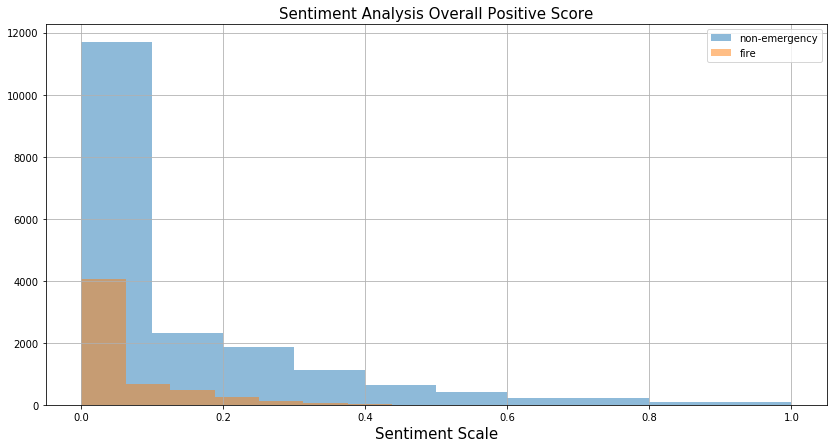

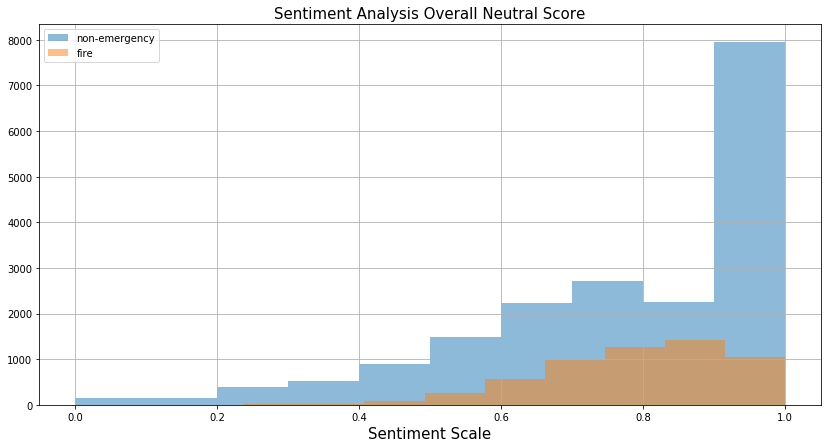

In [19]:
fig, ax1 = plt.subplots(1,1, figsize = (14,7))
labeled_df.groupby('target')['sia_compound'].hist(alpha = 0.5, ax = ax1)
ax1.legend(['non-emergency', 'fire'])
plt.title('Sentiment Analysis Overall Compound Score', fontsize = 15)
plt.xlabel('Sentiment Scale', fontsize = 15)
plt.show()

fig, ax2 = plt.subplots(1,1, figsize = (14,7))
labeled_df.groupby('target')['sia_negative'].hist(alpha = 0.5, ax = ax2)
ax2.legend(['non-emergency', 'fire'])
plt.title('Sentiment Analysis Overall Negative Score', fontsize = 15)
plt.xlabel('Sentiment Scale', fontsize = 15)
plt.show()

fig, ax3 = plt.subplots(1,1, figsize = (14,7))
labeled_df.groupby('target')['sia_positive'].hist(alpha = 0.5, ax = ax3)
ax3.legend(['non-emergency', 'fire'])
plt.title('Sentiment Analysis Overall Positive Score', fontsize = 15)
plt.xlabel('Sentiment Scale', fontsize = 15)
plt.show()


fig, ax4 = plt.subplots(1,1, figsize = (14,7))
labeled_df.groupby('target')['sia_neutral'].hist(alpha = 0.5, ax = ax4)
ax4.legend(['non-emergency', 'fire'])
plt.title('Sentiment Analysis Overall Neutral Score', fontsize = 15)
plt.xlabel('Sentiment Scale', fontsize = 15)
plt.show()

<Figure size 720x1440 with 0 Axes>

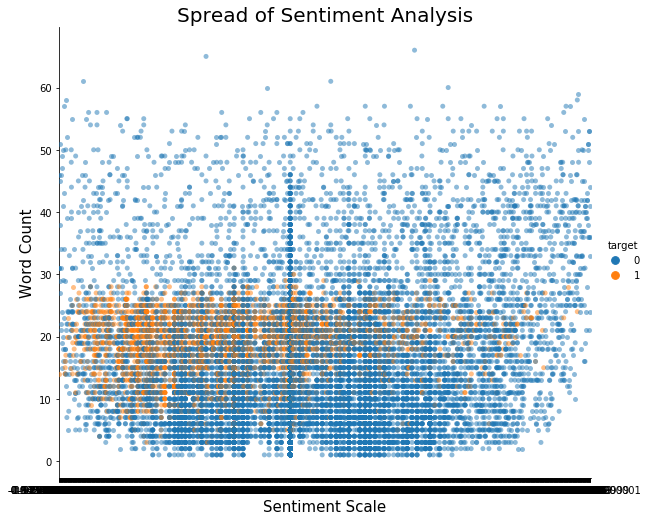

In [20]:
plt.figure(figsize = (10, 20))
sns.catplot(x = 'sia_compound', y ='word_count', hue = 'target', data=labeled_df, alpha = 0.5,
           height = 7, aspect = 1.2)

plt.xlabel("Sentiment Scale", fontsize = 15)
plt.ylabel("Word Count", fontsize = 15)
plt.title('Spread of Sentiment Analysis', fontsize = 20);

<Figure size 720x1440 with 0 Axes>

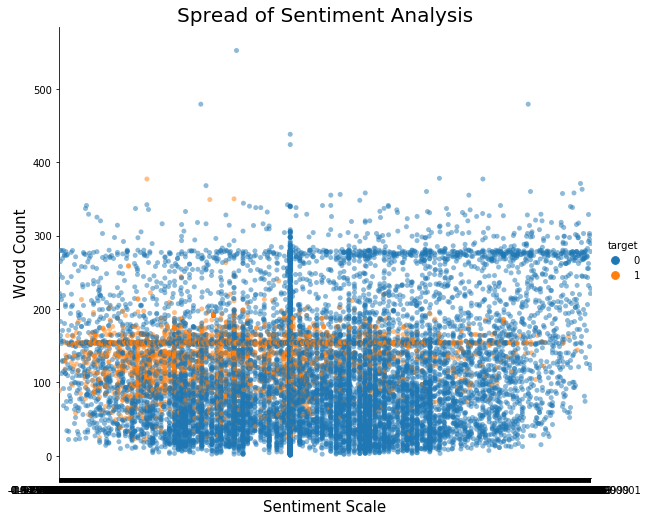

In [21]:
plt.figure(figsize = (10, 20))
sns.catplot(x = 'sia_compound', y ='character_count', hue = 'target', data=labeled_df, alpha = 0.5,
           height = 7, aspect = 1.2)

plt.xlabel("Sentiment Scale", fontsize = 15)
plt.ylabel("Word Count", fontsize = 15)
plt.title('Spread of Sentiment Analysis', fontsize = 20);

### N-Gram sentiment analysis

In [22]:
fire_negative = labeled_df.loc[(labeled_df['sia_compound'] < -0.49) & (labeled_df['target'] == 1)] 

In [23]:
labeled_df['target'].value_counts()

0    18719
1     5691
Name: target, dtype: int64

Out of the 5,691 targeted tweets, 1,362 have a compound sentiment score that is more than 0.59

In [24]:
fire_negative.shape

(1362, 16)

In [25]:
fire_negative.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound,word_count,character_count,mention_count,mention,https,newsom_mention,garcetti_mention,harris_mention,cal_fire
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859,22,174,1,1,0,0,0,0,0
5,1,RT @lacerci65: Watch \xe2\x80\x93 Evacuations ...,10/29/2019 22:55,0.000,0.227,0.773,-0.6124,19,163,2,1,1,0,0,0,0
8,1,California: 15% of Getty Fire contained ahead ...,10/29/2019 22:55,0.000,0.282,0.718,-0.6705,16,142,0,0,1,0,0,0,0
11,1,California: 15% of Getty Fire contained ahead ...,10/29/2019 22:55,0.000,0.282,0.718,-0.6705,16,142,0,0,1,0,0,0,0
14,1,"RT @gayandsweaty: ""______ has marked themselve...",10/29/2019 22:55,0.131,0.281,0.588,-0.5106,16,106,1,1,0,0,0,0,0


In [26]:
tfidf = TfidfVectorizer(stop_words = custom_stop, ngram_range=(1,1))

words_df = pd.DataFrame(
    tfidf.fit_transform(fire_negative['text']).todense(),
    columns = tfidf.get_feature_names()

)

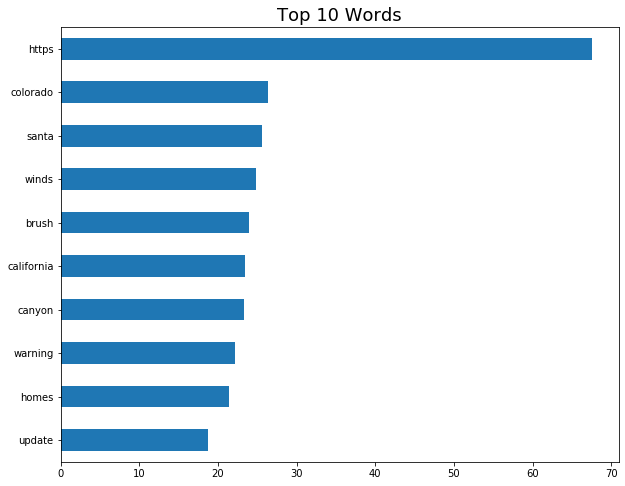

In [27]:
fire_n_10 = words_df.sum().sort_values(ascending = True).tail(10)
plt.title('Top 10 Words', fontsize = 18)
fire_n_10.plot.barh(figsize = (10,8))

In [28]:
tfidf = TfidfVectorizer(stop_words = custom_stop, ngram_range=(2,2))

bigram_df = pd.DataFrame(
    tfidf.fit_transform(fire_negative['text']).todense(),
    columns = tfidf.get_feature_names()

)

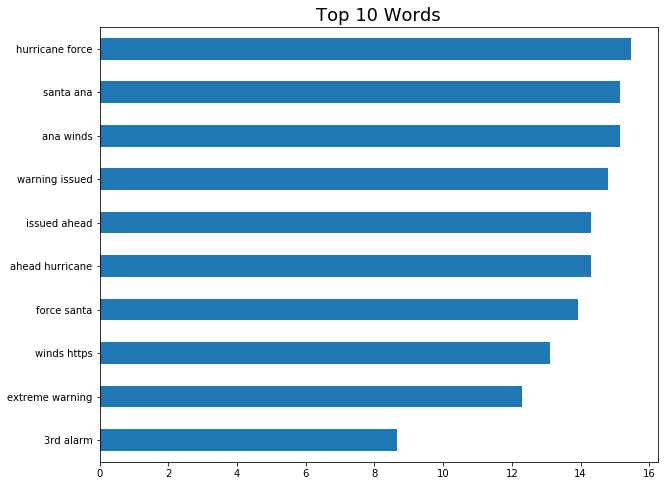

In [29]:
fire_n_b10 = bigram_df.sum().sort_values(ascending = True).tail(10)
plt.title('Top 10 Words', fontsize = 18)
fire_n_b10.plot.barh(figsize = (10,8))

In [31]:
tfidf = TfidfVectorizer(stop_words = custom_stop, ngram_range=(3,3))

trigram_df = pd.DataFrame(
    tfidf.fit_transform(fire_negative['text']).todense(),
    columns = tfidf.get_feature_names()

)

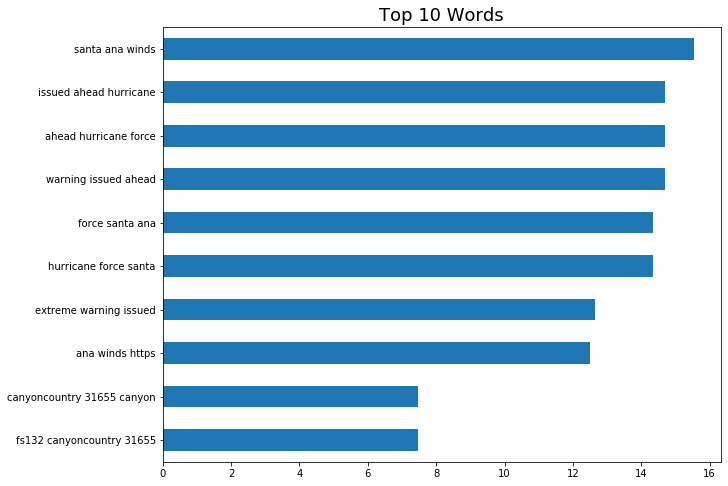

In [32]:
fire_n_t10 = trigram_df.sum().sort_values(ascending = True).tail(10)
plt.title('Top 10 Words', fontsize = 18)
fire_n_t10.plot.barh(figsize = (10,8))